# Phân loại viêm phổi từ ảnh X-ray sử dụng DenseNet-121

## ⚠️ Lưu ý quan trọng
Notebook này đã được **cải tiến** với tính năng tự động lưu checkpoint:
- ✅ **ModelCheckpoint**: Lưu model sau mỗi epoch
- ✅ **Best Model**: Lưu model tốt nhất dựa trên validation accuracy
- ✅ **Khôi phục**: Nếu training bị dừng, bạn có thể load lại checkpoint gần nhất

## 🔄 Cách khôi phục model nếu training bị dừng

```python
from tensorflow.keras.models import load_model

# Load model tốt nhất
model = load_model('../models/best_model_phase1.h5')

# Hoặc load checkpoint cụ thể
model = load_model('../models/checkpoint_phase1_epoch_10_val_acc_0.9234.h5')

# Tiếp tục training từ epoch đã dừng
history_continue = model.fit(
    train_generator,
    epochs=20,  # Tổng epochs muốn đạt
    initial_epoch=10,  # Epoch đã train xong
    validation_data=validation_generator,
    class_weight=train_class_weights,
    callbacks=[checkpoint_callback, best_model_callback]
)
```

---

### Bước 1: Import thư viện

### Bước 2: Chuẩn bị dữ liệu

**Quan trọng:** Bạn cần tải bộ dữ liệu [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) và giải nén vào thư mục `../data/`. 

Cấu trúc thư mục sau khi giải nén sẽ là:
```
data/
└── chest_xray/
    ├── test/
    │   ├── NORMAL/
    │   └── PNEUMONIA/
    ├── train/
    │   ├── NORMAL/
    │   └── PNEUMONIA/
    └── val/ 
        ├── NORMAL/
        └── PNEUMONIA/
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [2]:
BASE_PATH = '../data/chest_xray/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')
TEST_PATH = os.path.join(BASE_PATH, 'test')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

#### Tạo các `ImageDataGenerator`

Chúng ta sẽ áp dụng tăng cường dữ liệu (augmentation) cho tập huấn luyện để giúp mô hình tổng quát hóa tốt hơn.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Bước 3: Tính toán Class Weights

Để giải quyết vấn đề mất cân bằng dữ liệu, chúng ta sẽ tính toán trọng số cho mỗi lớp. Lớp có ít mẫu hơn sẽ có trọng số cao hơn.

In [4]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

train_class_weights = dict(enumerate(class_weights))
print("Class Weights:", train_class_weights)

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


### Bước 4: Xây dựng mô hình DenseNet-121

Chúng ta sẽ sử dụng kiến trúc DenseNet-121 đã được huấn luyện trước trên ImageNet và thay thế lớp phân loại cuối cùng.

In [5]:
# Tải base model DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp của base model
base_model.trainable = False

# Xây dựng các lớp phân loại mới
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Tạo mô hình hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Compile mô hình
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Bước 5: Huấn luyện mô hình (Giai đoạn 1 - Transfer Learning)

Ở giai đoạn này, chúng ta chỉ huấn luyện các lớp phân loại mới thêm vào.

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS_PHASE_1 = 50  # Tăng số epoch để đủ thời gian đạt 85%

# Tạo callbacks để lưu model tự động
checkpoint_callback = ModelCheckpoint(
    filepath='../models/checkpoint_phase1_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=False,  # Lưu mọi epoch để có thể khôi phục
    save_freq='epoch',
    verbose=1
)

best_model_callback = ModelCheckpoint(
    filepath='../models/best_model_phase1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Early stopping khi đạt 85% validation accuracy
class AccuracyThreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.85):
        super(AccuracyThreshold, self).__init__()
        self.threshold = threshold
    
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\n🎉 Đạt độ chính xác {val_acc*100:.2f}% >= {self.threshold*100}%! Dừng training.")
            self.model.stop_training = True

accuracy_threshold = AccuracyThreshold(threshold=0.85)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Tăng patience để có thời gian đạt 85%
    restore_best_weights=True,
    verbose=1
)

print("🚀 Bắt đầu Phase 1: Transfer Learning")
print(f"🎯 Mục tiêu: Đạt validation accuracy >= 85%")
print(f"📊 Số epoch tối đa: {EPOCHS_PHASE_1}")
print("-" * 60)

history = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE_1,
    validation_data=validation_generator,
    class_weight=train_class_weights,
    callbacks=[checkpoint_callback, best_model_callback, accuracy_threshold, early_stopping]
)

final_val_acc = history.history['val_accuracy'][-1]
print(f"\n✅ Phase 1 hoàn thành! Validation accuracy cuối cùng: {final_val_acc*100:.2f}%")

🚀 Bắt đầu Phase 1: Transfer Learning
🎯 Mục tiêu: Đạt validation accuracy >= 85%
📊 Số epoch tối đa: 50
------------------------------------------------------------
Epoch 1/50
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5785 - loss: 0.8361
Epoch 1: saving model to ../models/checkpoint_phase1_epoch_01_val_acc_0.7500.h5

Epoch 1: saving model to ../models/checkpoint_phase1_epoch_01_val_acc_0.7500.h5



Epoch 1: val_accuracy improved from None to 0.75000, saving model to ../models/best_model_phase1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.6419 - loss: 0.7007 - val_accuracy: 0.7500 - val_loss: 0.4474
Epoch 2/50
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7826 - loss: 0.4596
Epoch 2: saving model to ../models/checkpoint_phase1_epoch_02_val_acc_0.8750.h5

Epoch 2: saving model to ../models/checkpoint_phase1_epoch_02_val_acc_0.8750.h5



Epoch 2: val_accuracy improved from 0.75000 to 0.87500, saving model to ../models/best_model_phase1.h5



🎉 Đạt độ chính xác 87.50% >= 85.0%! Dừng training.
163/163 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7834 - loss: 0.4508 - val_accuracy: 0.8750 - val_loss: 0.4088
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 2.

✅ Phase 1 hoàn thành! Validation accuracy cuối cùng: 87.50%

✅ Phase 1 hoàn thành! Validation accuracy cuối cùng: 87.50%


### Bước 6: Huấn luyện mô hình (Giai đoạn 2 - Fine-tuning)

Bây giờ, chúng ta sẽ "mở băng" một vài lớp cuối của `base_model` để tinh chỉnh chúng trên bộ dữ liệu của chúng ta. Chúng ta cũng sẽ giảm `learning_rate` để tránh phá hỏng các trọng số đã học.

In [ ]:
# Mở băng các lớp cuối
base_model.trainable = True

# Giữ đóng băng các lớp đầu
# Ví dụ: chỉ fine-tune từ block cuối cùng trở đi
fine_tune_at = len(base_model.layers) // 2 # Ví dụ: mở 1/2 số lớp cuối

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile lại mô hình với learning rate thấp hơn
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate thấp hơn
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Tiếp tục huấn luyện
EPOCHS_PHASE_2 = 10
total_epochs = EPOCHS_PHASE_1 + EPOCHS_PHASE_2

# Callbacks cho phase 2 với tự động lưu
checkpoint_callback_phase2 = ModelCheckpoint(
    filepath='../models/checkpoint_phase2_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

best_model_callback_phase2 = ModelCheckpoint(
    filepath='../models/best_model_phase2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping_phase2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    class_weight=train_class_weights,
    callbacks=[checkpoint_callback_phase2, best_model_callback_phase2, early_stopping_phase2]
)

### Bước 7: Đánh giá mô hình

Lưu lại và trực quan hóa kết quả.

✅ Loaded best model from Phase 1


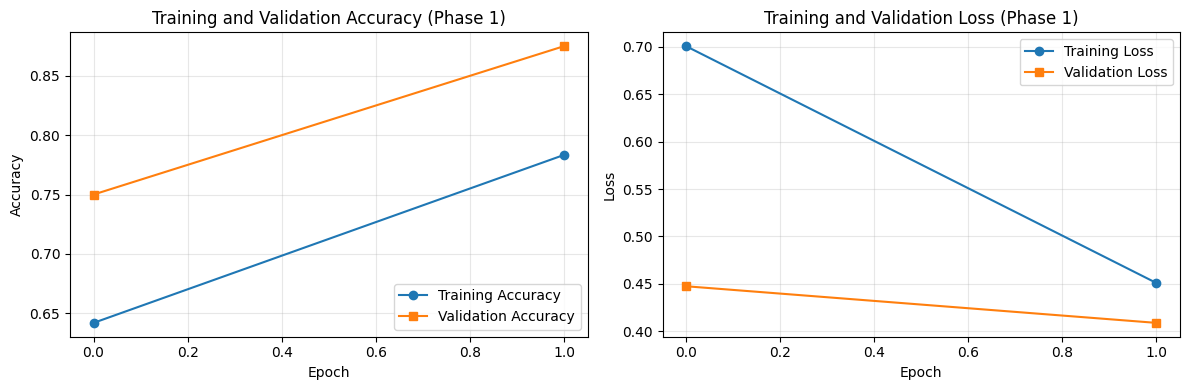


📊 EVALUATING ON TEST SET
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8446 - loss: 0.4127

✅ Test Loss: 0.4127
✅ Test Accuracy: 0.8446 (84.46%)

🔍 GENERATING PREDICTIONS
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step

📈 CONFUSION MATRIX


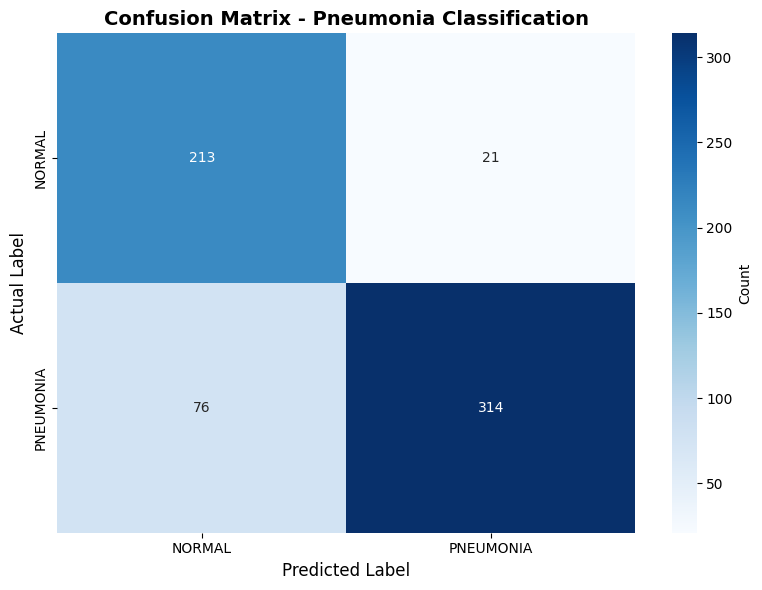


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       0.74      0.91      0.81       234
   PNEUMONIA       0.94      0.81      0.87       390

    accuracy                           0.84       624
   macro avg       0.84      0.86      0.84       624
weighted avg       0.86      0.84      0.85       624


✅ Evaluation completed!


In [10]:
# EVALUATION: Load best model và đánh giá
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load model tốt nhất
best_model = load_model('../models/best_model_phase1.h5')
print("✅ Loaded best model from Phase 1")

# 1. Vẽ training history (Phase 1 only)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Phase 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='s')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Phase 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Đánh giá trên test set
print("\n" + "="*50)
print("📊 EVALUATING ON TEST SET")
print("="*50)
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 3. Confusion Matrix và Classification Report
print("\n" + "="*50)
print("🔍 GENERATING PREDICTIONS")
print("="*50)
test_generator.reset()  # Reset để đảm bảo thứ tự
Y_pred = best_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (Y_pred > 0.5).astype(int).flatten()

print('\n' + "="*50)
print('📈 CONFUSION MATRIX')
print("="*50)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys(),
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Pneumonia Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n' + "="*50)
print('📋 CLASSIFICATION REPORT')
print("="*50)
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

print("\n✅ Evaluation completed!")

In [9]:
# 1. Vẽ biểu đồ Accuracy và Loss
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=EPOCHS_PHASE_1 - 1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=EPOCHS_PHASE_1 - 1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 2. Đánh giá trên tập test
print("\nEvaluating on test data...")
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 3. Ma trận nhầm lẫn và Báo cáo phân loại
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = (Y_pred > 0.5).astype(int).flatten()

print('\nConfusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

NameError: name 'history_fine' is not defined

### Bước 8: Lưu lại mô hình

Cuối cùng, lưu lại mô hình đã được fine-tune để sử dụng sau này.

In [ ]:
MODEL_SAVE_PATH = '../models/pneumonia_densenet121_v1.h5'
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")